In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

from nn.src.Losses import MSE
from nn.src.Optimizers import SGD, MomentumOptimizer, Adam
from nn.src.utils import ScalingTransformer, DataLoader, make_simple_sequential

os.chdir("..")

In [11]:
transformer = ScalingTransformer(-0.5, 0.5)
# df_train, df_test = pd.read_csv("../mio1/regression/square-large-training.csv"), pd.read_csv("../mio1/regression/square-large-test.csv")
# df_train, df_test = pd.read_csv("../mio1/regression/steps-large-training.csv"), pd.read_csv("../mio1/regression/steps-large-test.csv")
df_train, df_test = pd.read_csv("../mio1/regression/multimodal-large-training.csv"), pd.read_csv("../mio1/regression/multimodal-large-test.csv")
X_full_train, X_full_test = np.asarray(df_train["x"]), np.asarray(df_test["x"])
y_full_train, y_full_test = transformer.fit_transform(np.asarray(df_train["y"])), transformer.fit_transform(np.asarray(df_test["y"]))
dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)

In [12]:
def test_convergence_rate(dataloader, epochs, lr):
    scores = np.zeros((epochs,4))
    model_net = make_simple_sequential((1,5,5,1))
    nets = [ deepcopy(model_net) for _ in range(4)]
    optimizers = [SGD(nets[0].layers, lr),
                  MomentumOptimizer(nets[1].layers, lr),
                  Adam(nets[2].layers, lr, beta_1=0),
                  Adam(nets[3].layers, lr),
                  ]
    mse = MSE()
    for epoch in range(epochs):
        for (X,y) in dataloader:
            for net, optim in zip(nets, optimizers):
                y_hat = net(X)
                err = mse(y,y_hat)
                gradient = mse.derriv()
                net.backward(gradient)
                optim.step()
        for i, net in enumerate(nets):
            scores[epoch, i] = mse(transformer.inverse_transform(y_full_test), transformer.inverse_transform(net(X_full_test)))
        if not epoch % 1000:
            print(f"{epoch}/{epochs}")
    return scores

0 5258.906076332956


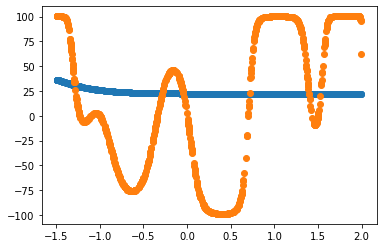

1000 5.2787018651564575


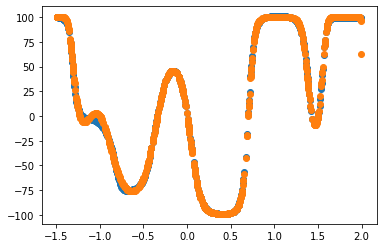

KeyboardInterrupt: 

In [13]:
# dataloader = DataLoader(X_full_train,y_full_train, batch_size=100)
# layers = [LinearLayer(1,5),
#           ReLU(),
#           LinearLayer(5,5),
#           ReLU(),
#           LinearLayer(5,1),
#           ]

net = make_simple_sequential((1,5,5,1))
# net = MLP(layers)
mse = MSE()
optim = Adam(net.layers, lr=0.1)
for epoch in range(10**6):
    for (X,y) in dataloader:
        y_hat = net(X)
        err = mse(y,y_hat)
        gradient = mse.derriv()
        net.backward(gradient)
        optim.step()
    if not epoch % 1000:
        plt.cla()
        print(epoch, mse(transformer.inverse_transform(y_full_test), transformer.inverse_transform(net(X_full_test))))
        plt.scatter(X_full_test, transformer.inverse_transform(net(X_full_test)))
        plt.scatter(X_full_test, transformer.inverse_transform(y_full_test))
        plt.show()

In [9]:
results = test_convergence_rate(dataloader, 1000, 0.1)

0/1000


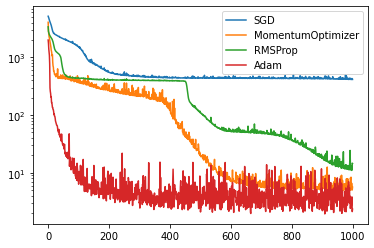

In [10]:
plt.plot(results)
plt.yscale('log')
plt.legend(("SGD", "MomentumOptimizer", "RMSProp", "Adam"))
